# Predictive Models 101

## Machine Learning in the Industry

The focus of this chapter is to talk about how we normally use **machine learning** in the industry. If you are not familiar with machine learning, you can see this chapter as a machine learning crash course. Still, if you've never worked with ML before, I strongly recommend you learn at least the basics to get the most out of what is to come. The rest of this book is aimed at Data Scientists who want to solve causal problems in their workplace. For this reason, I'll tend to assume you already have basic data science knowledge, including Machine Learning.  

But this doesn't mean you can should skip this chapter if you are versed in ML. I still think you will benefit from reading it through. Differently from other machine learning material, this one will **not** discuss the ins and outs of algorithms like decision trees or neural networks. Instead, it will be laser focused on **how machine learning is applied in the real world**.

One natural question is why are we talking about machine learning in a causal inference book? The short answer is because I think one of the best ways to understand causality is to put it in contrast with the predictive models approach brought by machine learning. The long answer is twofold. First, if you've got to this point in this book, there is a high chance you are already familiar with machine learning. Second, even if you are not, given the current popularity of these topics, you probably already have some idea on what they are. The only problem is that, with all the hype around machine learning, I might have to bring you back to earth and explain what machine learning really does in very practical terms.

As I've said in the beginning of the book, **machine learning is a way to make fast, automatic and good predictions**. That's not the entire picture, but we could say that it covers 90% of it. Its the field of supervised machine learning, where most of the cool advancements, like computer vision, self-driving cars, language translation and diagnostics, have been made. Notice how at first these might not seem like prediction tasks. How is language translation a prediction? And that's the beauty of machine learning. We can solve more problems with prediction than what is initially apparent. In the case of language translation, you can frame it as a prediction problem where you present a machine with one sentence and it has to predict the same sentence in another language. Here, I'm **not** using the word prediction in a forecasting or anticipating the future way. Prediction is simply learning how to map from one defined input to an equally well defined output. 

![img](./data/img/industry-ml/translation.png)

What machine learning really does is it learns this mapping function, even if it is very complicated. The bottom line is that if you can frame a problem as this mapping from an input to an output, then machine learning might be a good candidate to solve it. As for self driving cars, you can think of it as not one, but multiple complex prediction problems: predicting the correct angle of the wheel from sensors in the front of the car, prediction the pressure in the brakes from to images from cameras around the car, prediction pressure in the accelerator from gps data. Solving those (and a tone more) of prediction problems is what makes a self driving car.

OK… You now understand how prediction can be more powerful than we first though. Self-driving cars and language translation are cool and all, but they are quite distant, unless you work at a major tech company like Google or Uber. So, to make this more relatable, let's talk in terms of problems almost every company has: customer acquisition (that is getting new customers in case you are not familiar with the business jargon). 

From the customer acquisition perspective, what you often have to do is figure out who are the profitable customers. In this problem, each customer has a cost of acquisition (maybe marketing costs, onboarding costs, shipping costs...) and will hopefully generate a positive cashflow for the company. For example, let's say you are an internet provider or a gas company. Your typical customer might have a cash flow that looks something like this.

![img](./data/img/industry-ml/cashflow-1.png)

Each bar represents a monetary event in the life of your relationship with the customer. For example, to get a customer, right off the bet, you need to invest in marketing. Then, after someone decides to do business with you, you might incur in some sort of onboarding cost (where you have to explain to your customer how to use your product) or installation costs. Only then, the customer starts to generate monthly revenues. At some point, the customer might need some assistance and you will have maintenance costs. Finally, if the customer decides to end the contract, you might have some final costs for that too. 

To see if this is a profitable customer, we can rearrange the bar in what is called a cascade plot. Hopefully, the sum of the cash events end way up above the zero line.

![img](./data/img/industry-ml/cascade-1.png)

In contrast, it could very well be that the customer will generate much more costs than revenues. If he or she uses very little of your product and has high maintenance demands, when we pile up the cash events, they could end up below the zero line.

![img](./data/img/industry-ml/cascade-2.png)

Of course, this cash flow could be simpler or much more complicated, depending on the type of business. You can do stuff like time discount with an interest rate and get all crazy about it, but I think the point here is made.

But what can you do about this? Well, if you have many examples of profitable and non profitable customers, you can train a machine learning model to identify them. That way, you can focus your marketing strategies only on the profitable customers. Or, if your contract permits, you can end relations with a customer before he or she generates more costs. Essentially, what you are doing here, is framing the business problem as a prediction problem so that you can solve it with machine learning: you want to predict or identify profitable and unprofitable customers so that you only engage with the profitable ones.

In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

For instance, suppose you have 30 days of transactional data on 10000 customers. You also have the cost of acquisition `cacq`. This could be the bid you place for them if you are doing online marketing, it could be the cost of shipping or any training you have to do with your customer so they can use your product. Also, for the sake of simplicity (this is a crash course, not a semester on customer valuation), let's pretend you have total control of the customer that you do business with. In other words, you have the power to deny a customer even if he or she wants to do business with you. If that's the case, your task now becomes identifying who will be profitable beforehand, so you can choose to engage only with them.

In [2]:
transactions = pd.read_csv("data/customer_transactions.csv")
print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,6,0,73,10,0,0,0,21,...,0,0,0,0,0,0,0,0,0,0
1,1,-58,0,0,0,15,0,3,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,-7,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,3,2,0,9,0,0,0,...,0,0,40,0,0,0,0,0,0,0
4,4,-42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


What we need to do now is distinguish the good from the bad customers according to this transactional data. For the sake of simplicity, I'll just sum up all transactions and the CACQ. Keep in mind that this throws under the rug a lot of nuances, like distinguishing customers that churned from those that are in a break between one purchase and the next, but for our crash course it will do. 

I'll then join this sum, which I call `net_value`, with customer specific features. Since my goals is to figure out which customer will be profitable **before** deciding to engage whith them, you can only use data prior to the acquisition period. In our case, these features are age, region and income, which are available at another `csv` file.

In [3]:
profitable = (transactions[["customer_id"]]
              .assign(net_value = transactions
                      .drop(columns="customer_id")
                      .sum(axis=1)))

customer_features = (pd.read_csv("data/customer_features.csv")
                     .merge(profitable, on="customer_id"))

customer_features.head()

,customer_id,region,income,age,net_value
0,0,30,1025,24,130
1,1,41,1649,26,10
2,2,18,2034,33,-6
3,3,20,1859,35,136
4,4,1,1243,26,-8


Our task is becoming less abstract. We wish to identify the profitable customers (`net_value > 0`) from the non profitable ones. Let's try different things and see which one works better. But before that, we need to take a quick look into Machine Learning (feel free skip if you know how ML works) 

## Machine Learning Crash Course

For our intend and purpose, we can think of ML as an overpowered way of making predictions. For it to work, you need some data with labels or the ground truth of what you are predicting. Then, you can train a ML model on that data and use it to make predictions where the ground truth is not yet known. The image below exemplifies the typical machine learning flow.

![img](./data/img/industry-ml/ml-flow.png)

First, you need data where the groud truth, `net_value` here is known. Then, you train a ML model that will use features - region, income and age in our case - to predict `net_value`. This training or estimating process will produce a machine learning model that can be used to make predictions about `net_value` when you don't yet have the true `net_value`. This is shown in the left part of the image. You have some new data where you have the features region, income and age, but you don't know the `net_value` yet. So you pass this data through your model and it provides you with `net_value` predictions. 

One triky thing with ML models is that they can approximate almost any function. Another way of saying this is that they can be made so powerful as to perfectly fit the data in the training set. Machine learning models often have what we call complexity hyperparameters. These things adjust how powerful or complex the model can be. In the image below, you can see examples of a simple model, an intermediate model and a complex and powefull model. Notice how the complex model has a perfect fit of the training data.

![img](./data/img/industry-ml/model-fit.png)

This rises some problems. Namely, how can we know if our model is any good before using it to make predictions in the wield? One way we have is to compare the predictions with the actual values on the dataset where we have the ground truth. But remember that the model can be made so powerfull as to perfecly fit the data. If this happens, the predictions will perfectly match the ground truth. This is problematic, because it means this validation is misleading, since I can nailt it just by making my model more powefull and complex. 

Besides, it is generally **not** a good thing to have a very complex model. And you already have some intuition into why that is the case. In the image above, for instance, which model do you prefer? The more complex one that gets all the predictions right? Probably not. You probably preffer the middle one, that is smoother and simpler, even if that model doesn't perfectly fit the data.

Your intuition is in the right place. What happens if you give too much power to your model, is that it will not only learn the patterns in your data, but it also learn the random noise. Since the noise will be different when you use the model to make predictions in the real world (it's random after all), your perfect model will make mistakes. In ML terms, we say that models that are too complex are overfitting and don't generalize well. So, what can we do?

The idea is to split the dataset for wich we have the ground truth into two. Then, we can give one part of it for the model to train on and another part we can use to validate the model predictions. This is called corss validation as we will discuss it more latter. For now, you can see what hapens when we do that.

![img](./data/img/industry-ml/test.png)

In dataset above, which the model didn't saw during training, the complex model doesn't do a very good job. The modle in the middle, on the other hand, seems to performe better. To choose the right model complexity, we can train different models, each one with a different complexity, and see how they perform on some data that we have the ground truth, but that was not used for training the model.


## Cross Validation

Cross validation is essential for selecting the model complexity but it's more generally useful whenever we want to try many different things and estimate how they would play out in the real world. The idea being that we pretend no to have access to some of the data when estimating our ideas. Then, we can use this holdout data for evaluation. We can apply this to the whole problem of figuring out which customers are profitable or not. Here is an outline of what we should do

1. We have data on existing customers. On this data, we know which ones are profitables and which ones are not (we know the ground truth). Let's call our internal data the training set.
2. We will use the internal data to *learn* a rule that tells us which customer is profitable (hence training).
3. We will apply the rule to the holdout data that was **not** used for learning the rule. This should simulate the process of learning a rule in one dataset and applying it to another, a process that will be inevitable when we go to production and score truly unseen data.

Here is a picture of what cross validation looks like. There is the truly unseen data at the leftmost part of the image and then there is data that we only pretend not to have at learning time. 

![img](./data/img/industry-ml/cross-validation.png)

To summarize, we will partition our internal data into a training and a test set. We can use the training set to come up with models or rules that predict if a customer is profitable or not, but we will validate those rules in another partition of the dataset: the test set. This test set will be hidden from our learning procedure. The hope is that this will mimic the situation we will encounter once we go to production.

Just as a side note here, there are tons of ways to make cross validation better other than this simple train test split (k-fold cross-validation or temporal cross validation, for instance), but for the sake of what we will do here, this is enough. Remember that the key point of cross validation is to get more realistic estimates by evaluating our approach in a dataset that is different from the one in which it was built.

For our case, I'll divide the dataset into two. 70% will be used to build a method that allows us to identify profitable customers and 30% will be used to evaluate how good that method is.

In [4]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=13)
train.shape, test.shape

((7000, 5), (3000, 5))

## Predictions and Policies

We've been talking about methods and approaches to identify profitable customers but it is time we get more precise with our concepts. Let's introduce two. A **prediction** is a number that estimates or predicts something. For example, we can try to predict the profitability of a customer and the prediction would be something like 16 reais, meaning that we predict this customer to generate 16 reais in revenue. The point here is that prediction is a simple number. The second concept is that of a **policy**. A policy is an automatic decision rule. While a prediction is a number, a policy is a decision. For example, we can have a policy that engages with customers with income greater than 1000 and doesn't engage otherwise. We usually build policies on top of predictions: engage with all customers that have profitability predictions above 10 and don't engage otherwise. Machine learning will usually take care of the first, that is, of prediction. But notice that predictions alone are useless. We need to attach some decision, or policy to it.

We can do very simple policies and models or very complicated ones. For both policies and predictions, we need to use cross validation, that is, estimate the policy or prediction in one partition of the data and validate its usefulness in another. Since we've already partitioned our data into two, we are good to go.

## One Feature Policies

Before we go machine learning crazy on this problem, let's try the simple stuff first. The 80% gain with 20% effort stuff. They often work wonders and, surprising, most data scientists forget about them. So, what is the simplest thing we can do? Naturally, **just engage with all the customers!** Instead of figuring out which ones are profitable, let's just do business with everyone and hope the profitable customers more than compensate for the non profitable ones. 

To check if this is a good idea, we can see the average net value of the customers. If that turns out to be positive, it means that, on average, we will make money on our customers. Sure, there will be profitable and non profitable ones but, on average, if we have enough customers, we will make money. On the other hand, if this value is negative, it means that we will lose money if we engage with all the customers.

In [5]:
train["net_value"].mean()

-29.169428571428572

That's a bummer... If we engage with everyone, we would lose about 30 reais for customers we do business with. Our first, very simple thing didn't work and we better find something more promising if we don't want to go out of business. Just a quick side note here, keep in mind that this is a pedagogical example. Although the very simple, "treat everyone the same" kind of policy didn't work here, they often do in real life. It is usually the case that sending a marketing email to everyone is better than not sending it, or giving discounts coupons to everyone is often better than not giving them. 

Moving forward, what is the next simplest thing we can think of? One idea is taking our features and seeing if they alone distinguish the good from the bad customers. Take `income`, for instance. It's intuitive that richer customers should be more profitable, right? What if we do business only with the top richest customers? Would that be a good idea?

To figure this out we can partition our data into income quantiles (a quantile has the propriety of dividing the data into partitions of equal size, that's why I like them). Then, for each income quantile, let's compute the average net value. The hope here is that, although the average net value in negative, \\(E[NetValue]<0\\), there might be some subpopulation defined by income where the net value is positive, \\(E[NetValue|Income=x]<0\\), probably, higher income levels.

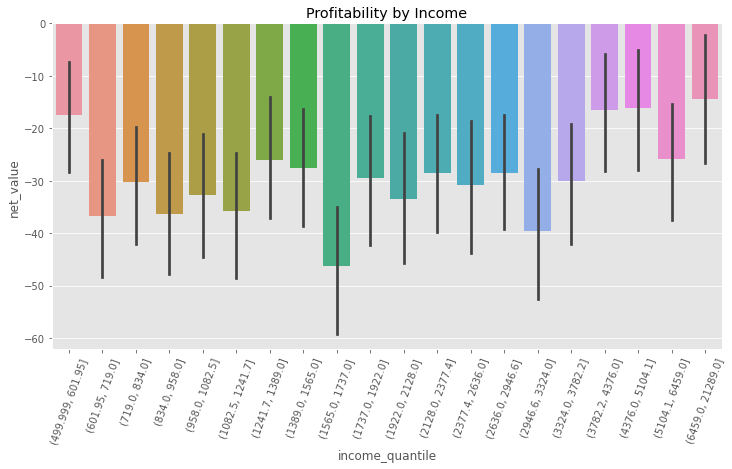

In [6]:
plt.figure(figsize=(12,6))
np.random.seed(123) ## seed because the CIs from seaborn uses boostrap

# pd.qcut create quantiles of a column
sns.barplot(data=train.assign(income_quantile=pd.qcut(train["income"], q=20)), 
            x="income_quantile", y="net_value")
plt.title("Profitability by Income")
plt.xticks(rotation=70);

And, sadly, nope. Yet again, all levels of income have negative average net value. Although it is true that richer customers are "less bad" than non rich customers, they still generate, on average, negative net value. So income didn't help us much here, but what about the other variables, like region? If most of our costs come, say, from having to serve customers in far away places, we should expect that the region distinguishes the profitable from the unprofitable customers.

Since region is already a categorical variable, we don't need to use quantiles here. Let's just see the average net value per region.

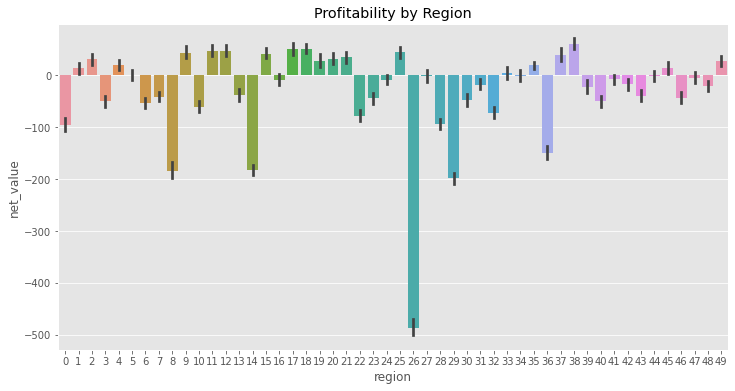

In [7]:
plt.figure(figsize=(12,6))
np.random.seed(123)
region_plot = sns.barplot(data=train, x="region", y="net_value")
plt.title("Profitability by Region");

Bingo! We can see clearly that some regions are profitable, like regions 2, 17, 39, and some are not profitable, like region 0, 9, 29 and the specially bad region 26. This is looking super promising! We can take this and transform into a policy: only do business with the regions that showed to be profitable *according to the data that we have here*. 

To construct this policy, we will be conservative and take only the regions where the lower end of the confidence interval is above zero. A region like 44 and 27, although slightly positive, will be left out according to this policy.

The following code extracts the lowest y value for each point in the plot above. The `enumerate` thing just zips each point with an index (0 to 49, since there are 50 points). We can do this only because the points are ordered from region 0 to 49. Then, the second dictionary generator filters only those where the lower end of the confidence interval is above zero. The result is the regions we will do business with according to our policy.

In [8]:
# extract the lower bound of the 95% CI from the plot above
regions_to_net = {region: line.get_ydata().min()
                  for region, line in enumerate(region_plot.lines)}

# filters regions where the net value is > 0.
regions_to_invest = {region: net 
                     for region, net in regions_to_net.items()
                     if net > 0}

regions_to_invest

{1: 3.1114864864864864,
 2: 20.618233082706766,
 4: 10.15546875,
 9: 32.921946564885495,
 11: 37.953947368421055,
 12: 37.38928571428571,
 15: 32.864179104477614,
 17: 40.09420289855072,
 18: 42.24804964539007,
 19: 16.361363636363638,
 20: 22.15404411764706,
 21: 24.625666666666667,
 25: 34.16416666666667,
 35: 12.041203703703705,
 37: 28.234642857142855,
 38: 50.015,
 45: 3.4688432835820895,
 49: 17.391447368421055}

`regions_to_invest` has all the regions we will engage with, according to this policy. Lets now see how this policy would have performed in our test set, the one we pretend not to have. This is a key step in evaluating our policy, because it could very well be that, simply by chance, a region in our training set is appearing to be profitable. If that is only due to randomness, it will be unlikely that we will find that same pattern in the test set.

To do so, we will filter the test set to contain only the customers in the regions defined as profitable (according to our training set). Then, we will plot the distribution of net income for those customers and also show the average net income of our policy.

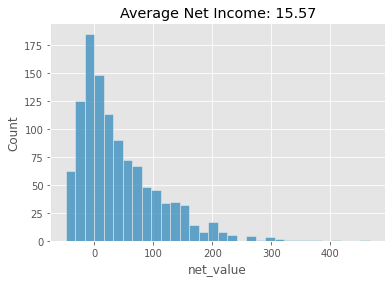

In [9]:
region_policy = (test[test["region"]
                      # filter regions in regions_to_invest
                      .isin(regions_to_invest.keys())]) 

sns.histplot(data=region_policy, x="net_value")
# average has to be over all customers, not just the one we've filtered with the policy
plt.title("Average Net Income: %.2f" % (region_policy["net_value"].sum() / test.shape[0]));

Not bad! If we use this very simple rule of doing business with only those regions, we can expect to gain about 15 reais per customer. Sure, out of the 3000 customers in the test set, we chose not to engage with some of them (gain of zero) and there will be some customer that we choose to engage with but made us lose money (the ones below zero in our histogram), but the profitable ones will more than compensate for that.

Now that you've figured this out, pat yourself in the back! It's already a super useful policy. Your boss will be super happy because your company can make money instead of losing it on customers. What an achievement! Let this be a lesson to never underestimate the value of simple policies.

## Machine Learning Models as Policy Inputs

If you are willing to do even better, we can now use the power of machine learning. Keep in mind that this will add tones of complexity to the whole thing and usually, only marginal gains. But, depending on the circumstances, marginal gains can be translated into huge piles of money and that's why machine learning is so valuable these days.

Here, I'll use a Gradient Boosting model. It's a fairly complicated model to explain, but it's very simple to use. For our purpose here, we don't need to get into the details of how it works. Instead, just remember what we've seen in our ML Crash course: a ML model is a super powerful predictive machine that has some complexity parameters. The more complex, the more powerful the model becomes. However, if the complexity is too high, the model will learn noise and not generalize well to unseen data. Hence, we need to use cross validation here to see if the model has the right complexity. 

Now, we need to ask, how can good predictions be used to improve upon our simple region policy to identify and engage with profitable customers? I think there are two main improvements that we can make here. First, you will have to agree that going through all the features looking for one that distinguishes good from bad customers is a cumbersome process. Here, we had only 3 of them (age, income and region), so it wasn't that bad, but imagine if we had more than 100. Also, you have to be careful with issues of [multiple testing](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) and false positive rates. The second reason is that it is probably the case that you need more than one feature to distinguish between customers. In our example, we have reasons to believe that features other than region also have some information on customer profitability. Sure, when we looked at income alone it didn't give us much, but what about income on those regions that are just barely unprofitable? Maybe, on those regions, if we focus only on richer customers, we could still get some profit. Coming up with these more complicated policies that involve interacting more than one feature can be super complex. The combinations we have to look at grows exponentially with the number of features and it is simply not a practical thing to do. Istead, what we can do is throw all those features into a machine learning model and have it learn those interactions for us. This is precisely what we will do next.

The goal of this model will be to predict `net_value` using `region`, `income`, `age`. To help it, we will take the region feature, which is categorical, and encode it with the lower end of the confidence interval of net income for that region. Remember that we have those stored in the `regions_to_net` dictionary? With this, all we have to do is call the method `.replace()` and pass this dictionary as the argument. I'll create a function for this, because we will do this replacement multiple times. This process of transforming features to facilitate the learning process is generally called feature engineering.

In [10]:
def encode(df): 
    return df.replace({"region": regions_to_net})

Next, our model will be imported from Sklearn. All their models have a pretty standard usage. First, you instantiate the model passing in the parameters. For this model, we will set the number of estimators to 400, the max depth to 4 and so on. These are the complexity hyperparameters we've talked about before. The deeper the model and the greater the number of estimators, the more powerful the model will be. Of course, we can't let it be too powerful, otherwise it will learn the noise in the training data or overfit to it. Again, you don't need to know the details of what these parameters do. Just keep in mind that this is a very good prediction model. Then, to train our model, we will call the `.fit()` method, passing the features `X` and the variable we want to predict - or target variable - `net_value`. 

In [11]:
model_params = {'n_estimators': 400,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"

np.random.seed(123)

reg = ensemble.GradientBoostingRegressor(**model_params)

# fit model on the training set
encoded_train = train[features].pipe(encode)
reg.fit(encoded_train, train[target]);

The model is trained. Now, we need to check if it is any good. To do this, we can look at the predictive performance of this model **on the test set**. There are tons of metrics to evaluate the predictive performance of a machine learning model. Here, I'll use one which is called \\(R^2\\). We don't need to get into much detail here. It suffices to say that the \\(R^2\\) is used to evaluate models that predict a continuous variable (like `net_income`). Also, \\(R^2\\) can go from minus infinity (it will be negative if the prediction is worse than the average) to 1.0. The \\(R^2\\) tells us how much of the variance in `net_income` is explained by our model.

In [12]:
train_pred = (encoded_train
              .assign(predictions=reg.predict(encoded_train[features])))

print("Train R2: ", r2_score(y_true=train[target], y_pred=train_pred["predictions"]))
print("Test R2: ", r2_score(y_true=test[target], y_pred=reg.predict(test[features].pipe(encode))))

Train R2:  0.7107000241611837
Test R2:  0.6937007775016534


In this case, the model explains about 71% of the `net_income` variance in the training set but only about 69% of the `net_income` variance in the test set. This is expected. Since the model had access to the training set, the performance there will often be overestimated. Just for fun (and to learn more about overfitting), try setting the 'max_depth' of the model to 14 and see what happens. You will likely see that the train \\(R^2\\) skyrockets but the test set \\(R^2\\) gets lower. This is what overfitting looks like. 

Next, in order to make our policy, we will store the test set predictions in a `prediction` column.

In [13]:
model_policy = test.assign(prediction=reg.predict(test[features].pipe(encode)))

model_policy.head()

,customer_id,region,income,age,net_value,prediction
5952,5952,19,1983,23,21,47.129807
1783,1783,31,914,31,-46,-34.273953
4811,4811,33,1349,25,-19,22.826486
145,145,20,1840,26,55,47.788507
7146,7146,19,3032,34,-17,4.756678


Just like we did with the `regions` feature, we can show the average net value by predictions of our model. Since the model is continuous and not categorical, we need to make it discrete first. One way of doing so is using pandas `pd.qcut` (by golly! I love this function!), which partitions the data into quantiles using the model prediction. Let's use 50 quantiles because 50 is the number of regions that we had. And just as a convention, I tend to call these model quantiles **model bands**, because it gives the intuition that this group has model predictions within a band, say, from -10 to 200. 

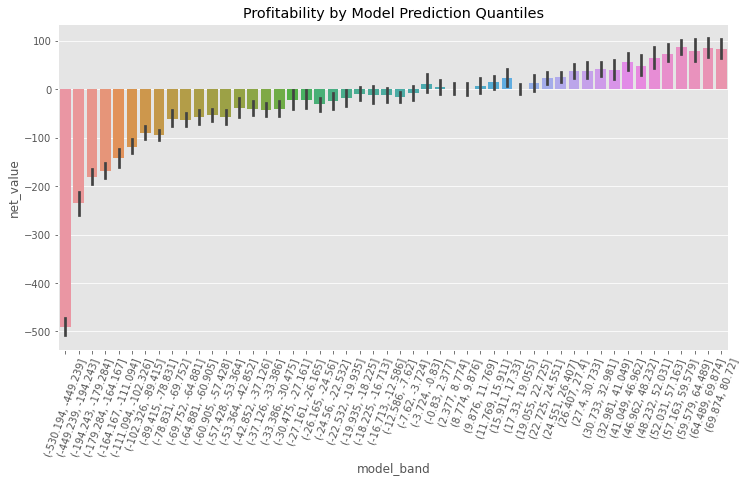

In [14]:
plt.figure(figsize=(12,6))

n_bands = 50
bands = [f"band_{b}" for b in range(1,n_bands+1)]

np.random.seed(123)
model_plot = sns.barplot(data=model_policy
                         .assign(model_band = pd.qcut(model_policy["prediction"], q=n_bands)),
                         x="model_band", y="net_value")
plt.title("Profitability by Model Prediction Quantiles")
plt.xticks(rotation=70);

Here, notice how there are model bands where the net value is super negative, while there are also bands where it is very positive. Also, there are bands where we don't know exactly if the net value is negative or positive. Finally, notice how they have an upward trend, from left to right. Since we are predicting net income, it is expected that the prediction will be proportional to what it predicts, if the model is any good.

Now, to compare this policy using a machine learning model with the one using only the regions we can also show the histogram of net gains, along with the total net value in the test set.

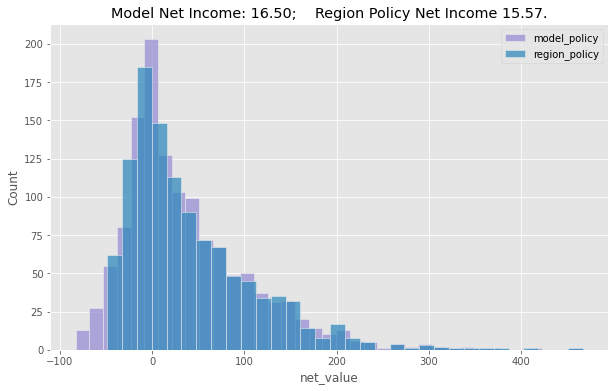

In [15]:
plt.figure(figsize=(10,6))
model_plot_df = (model_policy[model_policy["prediction"]>0])
sns.histplot(data=model_plot_df, x="net_value", color="C2", label="model_policy")

region_plot_df = (model_policy[model_policy["region"].isin(regions_to_invest.keys())])
sns.histplot(data=region_plot_df, x="net_value", label="region_policy")

plt.title("Model Net Income: %.2f;    Region Policy Net Income %.2f." % 
          (model_plot_df["net_value"].sum() / test.shape[0],
           region_plot_df["net_value"].sum() / test.shape[0]))
plt.legend();

As we can see, the model generates a better policy than just using the regions feature, but not by much. While the model policy would have made us about 16.6 reais / customer on the test set, the region policy would have made us only 15.5 / customer. It's just slightly better, but if you have tons and tons of customers, this might already justify using a model instead of a simple one feature policy.


## Fine Grain Policy

As a recap, so far, we tested the most simple of all policies, which is just engaging with all the customers. Since that didn't work (the average net income per customer was negative), we developed a single feature policy that was based on regions: we would do business in some regions, but not in others. This already gave us very good results. Next, we went full machine learning, with a predictive model. Then, we used that model as an input to a policy and chose to do business with all the customers whose net income predictions were above zero.

Here, the decision which the policy handles is very simple: engage with a customer or don't engage. The policies we had so far dealt with the binary case. They were in the form of

```
if prediction > 0 then do business else don't do business.
```

This is something we call **thresholding**. If the prediction exceeds a certain threshold (zero in our case, but could be something else), we take one decision, if it doesn't, we take another. One other example of where this could be applied in real life is transactional fraud detection: if the prediction score of a model that detects fraud is above some threshold `X`, we deny the transaction, otherwise we approve it.

Thresholding works in lots of real case scenarios and it is particularly useful when the nature of the decision is binary. However, we can think of cases where things tend to be more nuanced. For example, you might be willing to spend more in marketing to get the attention of very profitable customers. Or you might want to add them to some prime customers list, where you give special treatment to them, but it also costs you more to do so. Notice that if we include these possibilities, your decision goes from binary (engage vs don't engage) to continuous: how much should you invest in a customer.

Here, for the next example, suppose your decision is not just who to do business with, but how much marketing costs you should invest in each customer. And for the sake of the example, assume that you are competing with other firms and whoever spends more on marketing in a particular customer wins that customer (much like a bidding mechanism). In that case, it makes sense to invest more in highly profitable customers, less in marginally profitable customers and not at all in non profitable customers.

One way to do that is to descritize your predictions into bands. We've done this previously for the purpose of model comparison, but here we will do it for decision making. Let's create 20 bands. We can think of those as quantiles or equal size groups. The first band will contain the 5% less profitable customers *according to our predictions*, the second band will contain from the 5% to the 10% less profitable and so on. The last band, 20, will contain the most profitable customers.

Notice that the binning too has to be estimated on the training set and applied on the test set! For this reason, we will compute the bins using `pd.qcut` on the training set. To actually do the binning, we will use `np.digitize`, passing the bins that where precomputed on the training set.

In [16]:
def model_binner(prediction_column, bins):
    # find the bins according to the training set
    bands = pd.qcut(prediction_column, q=bins, retbins=True)[1]
    
    def binner_function(prediction_column):
        return np.digitize(prediction_column, bands)
    
    return binner_function
    

# train the bining function
binner_fn = model_binner(train_pred["predictions"], 20)

# apply the binning
model_band = model_policy.assign(bands = binner_fn(model_policy["prediction"]))
model_band.head()

,customer_id,region,income,age,net_value,prediction,bands
5952,5952,19,1983,23,21,47.129807,18
1783,1783,31,914,31,-46,-34.273953,7
4811,4811,33,1349,25,-19,22.826486,15
145,145,20,1840,26,55,47.788507,18
7146,7146,19,3032,34,-17,4.756678,13


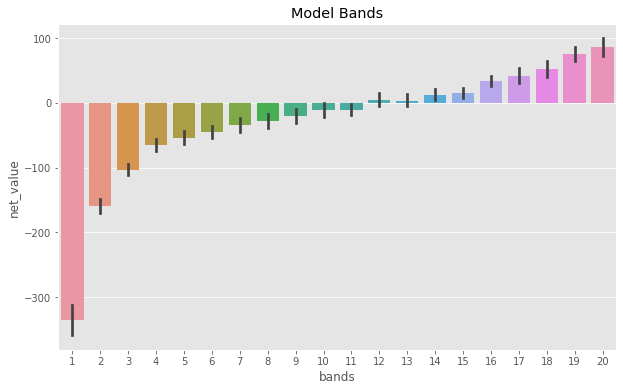

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(data=model_band, x="bands", y="net_value")
plt.title("Model Bands");

With these bands, we can allocate the bulk of our marketing investments to band 20 and 19. Notice how we went from a binary decision (engage vs not engage), to a continuous one: how much to invest on marketing for each customer. Of course you can fine tune this even more, adding more bands. In the limit, you are not binning at all. Instead, you are using the raw prediction of the model and you can create decision rules like

```
mkt_investments_i = model_prediction_i * 0.3
```

where for each customer \\(i\\), you invest 30% of the net_value predicted by the model (30% was an arbitrary number, but you get the point).

## Key Ideas

We've covered A LOT of ground here in a very short time, so I think this recap is extremely relevant for us to see what we accomplished here. First, we learned how the majority of machine learning applications involves nothing more than making good predictions, where prediction is understood as mapping from a known input to an initially unknown, but well defined output. But when I say "nothing more", I'm not being entirely fair. We also saw how good predictions can solve more problems than we might think at first, like language translation and self driving cars. 

Then, we got back down to earth and looked at how good predictions can help us with more common tasks, like figuring out which customer we should bring in and which to avoid. Specifically, we looked at how we could predict customer profit. With that prediction, we've built a policy that decides who we should do business with. Notice that this is just an example of where prediction models can be applied. There are sure tones of other ones, like credit card underwriting, fraud detection, cancer diagnostics and anything else where good predictions might be useful.

The key takeaway here is that **if you can frame your business problem as a prediction problem, machine learning is probably a good tool for the job**. I really can't emphasize this enough. With all the hype around machine learning, I feel that people forgot about this very important point and often end up making models that are very good in predicting something totally useless. Instead of thinking about how to frame a business problem as a prediction problem and *then* solving it with machine learning, they often build a prediction model and try to see what business problem could benefit from that prediction. This might work, but, more often than not, is a shot in the dark that only generates solutions in search of a problem.

## References 

The things I've written here are mostly stuff from my head. I've learned through experience. This means there isn't a direct reference I can point you to. It also means that the things that I wrote here have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts. 

Finally, I believe I might have been too quick for those who were hoping for a comprehensive and detailed introduction of machine learning. To be honest, I believe that where I can truly generate value is teaching about causal inference, not machine learning. For the latter, there are tons of amazing online resources, much better than I could ever dream of creating. The classical one is [Andrew Ng's course on Machine Learning](https://www.coursera.org/learn/machine-learning) and I defenlty recoment you take a look into it if you are new to machine learning. **From now on, I'll assume basic ML knowlage**. 